    # MLP for Heart Shape Classification

    This notebook demonstrates how to train a Multi-Layer Perceptron (MLP) to classify points belonging to a heart shape. We will use either PyTorch or a custom framework called `tensorweaver` for this task.

In [1]:
ML_FRAMEWORK = "tensorweaver"

if ML_FRAMEWORK == "tensorweaver":
    import tensorweaver as torch
    import tensorweaver.nn as nn
    import tensorweaver.optim as optim
    from tensorweaver.utils.data import TensorDataset, DataLoader
else:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

    ## 1. Data Generation

    We start by generating a dataset. The data points are 2D coordinates, and the labels indicate whether a point lies inside or outside a heart shape. The heart shape is defined by an implicit function.

In [2]:
# Data Generation
def heart_fn(x, y):
    # Heart shape implicit function: <=0 indicates the interior
    return (x**2 + y**2 - 1)**3 - x**2 * y**3

# Randomly generate points and assign labels
np.random.seed(42)
n_samples = 5000
XY = np.random.uniform(-1.5, 1.5, size=(n_samples, 2))
labels = (heart_fn(XY[:,0], XY[:,1]) <= 0).astype(np.float32)

### Visualizing the Raw Data

Let's take a look at the generated data points. The scatter plot below shows the 2D points, colored by whether they are inside (typically one color) or outside (another color) the heart shape.

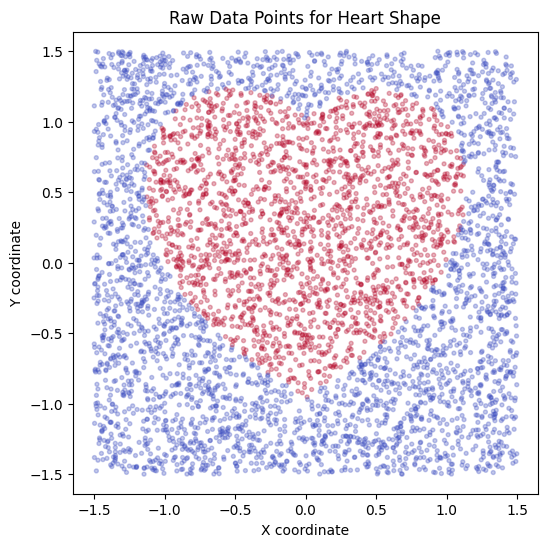

In [3]:
plt.figure(figsize=(6,6))
plt.scatter(XY[:,0], XY[:,1], c=labels, cmap='coolwarm', s=8, alpha=0.3)
plt.axis('equal')
plt.title("Raw Data Points for Heart Shape")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.show()

In [4]:
# Convert to TensorDataset
X_tensor = torch.Tensor(XY)
y_tensor = torch.Tensor(labels)
dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=128, shuffle=True)


# Define MLP Model
class HeartMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(2, 64)
        self.relu1 = nn.ReLU()
        self.l2 = nn.Linear(64, 64)
        self.relu2 = nn.ReLU()
        self.l3 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.l1(x)
        x = self.relu1(x)
        x = self.l2(x)
        x = self.relu2(x)
        x = self.l3(x)
        return x

    ## 3. Training Loop

    Now, we set up the training process. This involves:
    - Initializing the MLP model.
    - Defining a loss function (Cross-Entropy Loss).
    - Choosing an optimizer (Adam).
    - Iterating through the data for a specified number of epochs, updating the model weights at each step.

In [ ]:
model = HeartMLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training Loop
num_epochs = 100
for epoch in range(1, num_epochs+1):
    model.train()
    total_loss = 0.0
    for xb, yb in loader:
        logits = model(xb)
        loss = criterion(logits, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    if epoch % 10 == 0 or epoch == 1:
        avg_loss = total_loss / n_samples
        print(f"Epoch {epoch:03d} | Loss: {avg_loss:.4f}")

Epoch 001 | Loss: 0.5803
Epoch 010 | Loss: 0.0574
Epoch 020 | Loss: 0.0455
Epoch 030 | Loss: 0.0378
Epoch 040 | Loss: 0.0375


    ## 4. Visualize Decision Boundary

    Finally, we visualize the decision boundary learned by our MLP. We'll plot:
    - The original data points, colored by their true labels.
    - The true boundary of the heart shape (solid black line).
    - The decision boundary learned by the MLP (dashed yellow line), representing the 0.5 probability contour.

In [ ]:
# Visualize Decision Boundary
model.eval()
# Construct meshgrid
xx, yy = np.meshgrid(np.linspace(-1.5, 1.5, 400),
                     np.linspace(-1.5, 1.5, 400))
grid = np.c_[xx.ravel(), yy.ravel()]
with torch.no_grad():
    logits = model(torch.Tensor(grid))
    probs = torch.softmax(logits, dim=1)[:,1].numpy().reshape(xx.shape)

# Plotting
plt.figure(figsize=(6,6))
# True heart shape boundary
plt.contour(xx, yy, heart_fn(xx, yy), levels=[0], colors='black', linewidths=2, linestyles='solid')
# Model's predicted 0.5 decision boundary
plt.contour(xx, yy, probs, levels=[0.5], colors='yellow', linewidths=2, linestyles='dashed')
plt.scatter(XY[:,0], XY[:,1], c=labels, cmap='coolwarm', s=8, alpha=0.3)
plt.axis('equal')
plt.title("Heart Shape: True Boundary (black) vs. MLP Boundary (yellow dashed)")
plt.show()